# Assignment 3
## Dog Breeds
## Arsenii Belyakov
### 450835

### uploading used libraries 

In [1]:
import os
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from keras_applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

## Load data (wrong version, idk why)

dataList = os.listdir("../stanford-dogs-dataset/images/Images/") # os.listdir() method in python is used to get the list of all files and directories in the specified directory.
numOfClasses = len(dataList)
usedClasses = 6
imageCounter = 0
for dataClass in dataList:
    imageCounter+=len(os.listdir("../stanford-dogs-dataset/images/Images/"
                     .format(dataClass))) 
print(imageCounter)
print(numOfClasses)



## Load data 

In [2]:
# os.listdir() method in python is used to get the list of all files and directories in the specified directory.
breed_list = os.listdir("../stanford-dogs-dataset/images/Images/")
usedBreeds = 5

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("../stanford-dogs-dataset/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


## Split data

Creating directroies and subdirectories for data

In [3]:
os.makedirs('data',exist_ok=True) #Like mkdir(), but makes all intermediate-level directories needed to contain the leaf directory.
os.makedirs('data/Train',exist_ok= True)
os.makedirs('data/Validate',exist_ok= True) 


Creating subbdirectories for breeds, which will be used

In [4]:
usedClasses = 1

for breed in breed_list:
    os.makedirs('data/Train/'+breed,exist_ok= True)
    os.makedirs('data/Validate/'+breed,exist_ok= True)
    if usedClasses >= usedBreeds: #reached limit of used breads
        break
    usedClasses+=1

    Save data into folders
cpt - Conditional probability table

In [5]:
validationToTraining = .1
breed_in_use = 1

for breed in os.listdir('data/Train/'):

    # walk() generates the file names in a directory tree by walking the tree either top-down or bottom-up.
    cpt = sum([len(files) for root, directory, files in os.walk('../stanford-dogs-dataset/images/Images/{}/'.format(breed))])
    validation = (int)(cpt*validationToTraining)
    index = 0
    
    for file in os.listdir('../stanford-dogs-dataset/annotations/Annotation/{}'.format(breed)):
        
        img = Image.open('../stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file))
        img = img.convert('RGB')
        
        if index<validation: #to make propper split
            img.save('data/Validate/' + breed + '/' + file + '.jpg')

        else:
            img.save('data/Train/' + breed + '/' + file + '.jpg')
        index += 1
        
    if breed_in_use == usedBreeds: #check if we are still in our limit
        break
        
    breed_in_use = breed_in_use+1
            

print(len(os.listdir('data/Train')))
print(len(os.listdir('data/Validate')))
            

5
5


# Step 1
## Build an input pipeline using the tf.data.Dataset API and/or keras.preprocessing.image API that loads the images, resizes them to the same resolution and applies some basic data augmentation like translation, rotation, etc. It should also prefetch the images

Resizing data to the same resolution

Applying agumentation for train_datagen

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [6]:
train_dir = 'data/Train'
validation_dir = 'data/Validate'
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

# No agumentation for validation data
test_datagen = ImageDataGenerator(rescale = 1.0/255.)


Build an input pipeline

In [7]:
# Flow training images in batches of 50 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 10,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150),
                                                          shuffle=True)

Found 837 images belonging to 5 classes.
Found 90 images belonging to 5 classes.


# Step 2
## Build your own CNN and try to train it on the data set - plot the learning curves and experiment with the hyperparameters, observe how bad the results are.

Conv2D - https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

MaxPooling2D - https://www.tensorflow.org/api_docs/python/tf/compat/v1/layers/MaxPooling2D

dropout - https://www.tensorflow.org/api_docs/python/tf/nn/dropout

Flatten - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

Dense - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

In [8]:
def create_model():
        model = Sequential()
        model.add(Conv2D(32, (3, 3), 
                         activation='relu', 
                         kernel_initializer='he_uniform', 
                         padding='same', 
                         input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', 
                         kernel_initializer='he_uniform', 
                         padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', 
                        kernel_initializer='he_uniform'))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(usedClasses, 
                        activation='softmax'))
        model.compile(optimizer="adam", 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        return model

In [9]:
np.random.seed(10)
datagen = ImageDataGenerator(rescale=1.0/255.0)
dataset = datagen.flow_from_directory(train_dir, 
                                      class_mode='categorical',
                                      target_size = (150, 150))

Found 837 images belonging to 5 classes.


In [10]:
X, Y = dataset.next()
model_grid = KerasClassifier(build_fn=create_model,
                             verbose=0)
batch_size = [10, 20, 30, 40, 80]
epochs = [10, 20, 50]
hyperparameters = dict(batch_size=batch_size,
                       epochs=epochs)

In [11]:
grid = GridSearchCV(estimator=model_grid,
                    param_grid=hyperparameters,
                    n_jobs=1, 
                    cv=3,
                    verbose = 0)

In [12]:
%%time
grid_result = grid.fit(X, Y)

/Users/arseniybelyakov/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 1h 48min 53s, sys: 2min 51s, total: 1h 51min 45s
Wall time: 13min 13s


In [13]:
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means,
                              stds,
                              params):
    print("%f (%f) with: %r" % (mean,
                                stdev,
                                param))

Best: 0.250000 using {'batch_size': 30, 'epochs': 10}
0.062500 (0.045383) with: {'batch_size': 10, 'epochs': 10}
0.031250 (0.046351) with: {'batch_size': 10, 'epochs': 20}
0.125000 (0.041286) with: {'batch_size': 10, 'epochs': 50}
0.156250 (0.084380) with: {'batch_size': 20, 'epochs': 10}
0.250000 (0.172712) with: {'batch_size': 20, 'epochs': 20}
0.093750 (0.075496) with: {'batch_size': 20, 'epochs': 50}
0.250000 (0.226134) with: {'batch_size': 30, 'epochs': 10}
0.093750 (0.080943) with: {'batch_size': 30, 'epochs': 20}
0.187500 (0.127531) with: {'batch_size': 30, 'epochs': 50}
0.250000 (0.168550) with: {'batch_size': 40, 'epochs': 10}
0.187500 (0.075847) with: {'batch_size': 40, 'epochs': 20}
0.187500 (0.008427) with: {'batch_size': 40, 'epochs': 50}
0.125000 (0.041286) with: {'batch_size': 80, 'epochs': 10}
0.218750 (0.127879) with: {'batch_size': 80, 'epochs': 20}
0.125000 (0.041286) with: {'batch_size': 80, 'epochs': 50}


In [14]:
batch_size_cv = grid_result.best_params_['batch_size']
epochs_cv = grid_result.best_params_['epochs']

In [15]:
datasets = datagen.flow_from_directory(train_dir,
                                       batch_size = batch_size_cv,
                                       class_mode='categorical',
                                       target_size = (150, 150))

Found 837 images belonging to 5 classes.


In [16]:
model = create_model()

In [17]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 20,
            validation_steps = 9,
            verbose = 1
)


Epoch 1/20
20/20 [==============================] - 45s 2s/step - loss: 11.6627 - accuracy: 0.2444 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 2/20
20/20 [==============================] - 45s 2s/step - loss: 12.0725 - accuracy: 0.2510 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 3/20
20/20 [==============================] - 44s 2s/step - loss: 12.0509 - accuracy: 0.2526 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 4/20
20/20 [==============================] - 44s 2s/step - loss: 11.9998 - accuracy: 0.2543 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 5/20
20/20 [==============================] - 45s 2s/step - loss: 12.2633 - accuracy: 0.2391 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 6/20
20/20 [==============================] - 45s 2s/step - loss: 12.0375 - accuracy: 0.2533 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 7/20
20/20 [==============================] - 45s 2s/step - loss: 11.8977 - accuracy: 0.2624 - val_loss: 11.9990 - val_accuracy: 0.2556
Epoch 

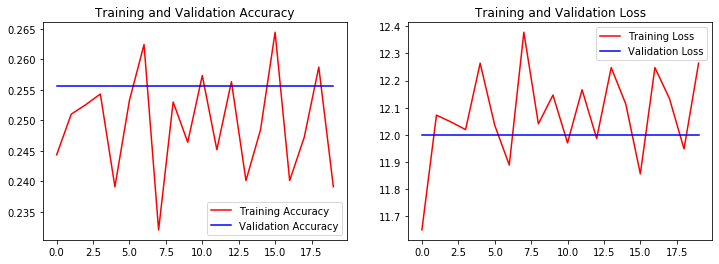

In [18]:
my_acc = history.history['accuracy']
my_val_acc = history.history['val_accuracy']
my_loss = history.history['loss']
my_val_loss = history.history['val_loss']

epochs = range(len(my_acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, my_acc, 'r', label='Training Accuracy')
plt.plot(epochs, my_val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.legend(loc=0)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, my_loss, 'r', label='Training Loss')
plt.plot(epochs, my_val_loss, 'b',  label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Step 3
## 3. Use transfer learning to learn at least two pre-trained networks from keras.applications - try applying different strategies to training your model (e.g. adding more than one dense layer at the end, training only a part of the pre-trained network, etc.)

### 3.1 InceptionV3
InceptionV3 - https://keras.io/applications/#inceptionv3

In [19]:
InceptionV3_pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False)
for layer in InceptionV3_pre_trained_model.layers:
    layer.trainable = False

InceptionV3_pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
last_layer_InceptionV3 = InceptionV3_pre_trained_model.get_layer('mixed7')
print('InceptionV3 last layer output shape: ', last_layer_InceptionV3.output_shape)
InceptionV3_last_output = last_layer_InceptionV3.output

InceptionV3 last layer output shape:  (None, 7, 7, 768)


### Dense Layer:

A dense layer represents a matrix vector multiplication. (assuming your batch size is 1) The values in the matrix are the trainable parameters which get updated during backpropagation.

#### 𝑢𝑇.𝑊,𝑊∈𝑅𝑛×𝑚

So you get a m dimensional vector as output. A dense layer thus is used to change the dimensions of your vector. Mathematically speaking, it applies a rotation, scaling, translation transform to your vector.

https://www.quora.com/In-Keras-what-is-a-dense-and-a-dropout-layer

In [21]:
x_InceptionV3 = layers.Flatten()(InceptionV3_last_output)                                 # Flattens the input. Does not affect the batch size. Puts everything in 1 dimension
# разобрать эту дичь - https://keras.io/activations/
x_InceptionV3 = layers.Dense(512, activation='relu')(x_InceptionV3)                       # Has 1,024 hidden units and ReLU activation
x_InceptionV3 = layers.Dropout(0.25)(x_InceptionV3)             
x_InceptionV3 = layers.Dense  (usedBreeds, activation='softmax')(x_InceptionV3) # Add a final sigmoid layer for classification         
InceptionV3_model = Model( InceptionV3_pre_trained_model.input, x_InceptionV3) 
InceptionV3_model.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

history_InceptionV3 = InceptionV3_model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 16,
            epochs = 20,
            validation_steps = 9,
            verbose = 2
)

Epoch 1/20
16/16 - 131s - loss: 2.8796 - acc: 0.3799 - val_loss: 0.9689 - val_acc: 0.7222
Epoch 2/20
16/16 - 130s - loss: 0.9962 - acc: 0.6531 - val_loss: 0.4572 - val_acc: 0.8889
Epoch 3/20
16/16 - 126s - loss: 0.7084 - acc: 0.7625 - val_loss: 0.3755 - val_acc: 0.8889
Epoch 4/20
16/16 - 122s - loss: 0.6169 - acc: 0.7868 - val_loss: 0.3594 - val_acc: 0.9222
Epoch 5/20
16/16 - 125s - loss: 0.5869 - acc: 0.8012 - val_loss: 0.4879 - val_acc: 0.8889
Epoch 6/20
16/16 - 124s - loss: 0.5447 - acc: 0.8170 - val_loss: 0.3338 - val_acc: 0.9000
Epoch 7/20
16/16 - 122s - loss: 0.5407 - acc: 0.7972 - val_loss: 0.3026 - val_acc: 0.9000
Epoch 8/20
16/16 - 123s - loss: 0.4718 - acc: 0.8437 - val_loss: 0.2710 - val_acc: 0.9222
Epoch 9/20
16/16 - 123s - loss: 0.4833 - acc: 0.8463 - val_loss: 0.2069 - val_acc: 0.9000
Epoch 10/20
16/16 - 125s - loss: 0.3657 - acc: 0.8712 - val_loss: 0.1810 - val_acc: 0.9333
Epoch 11/20
16/16 - 122s - loss: 0.3985 - acc: 0.8450 - val_loss: 0.2642 - val_acc: 0.9111
Epoch 12

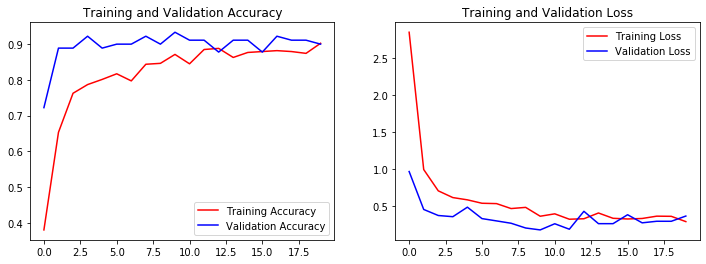

In [22]:
acc = history_InceptionV3.history['acc']
val_acc = history_InceptionV3.history['val_acc']
loss = history_InceptionV3.history['loss']
val_loss = history_InceptionV3.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.legend(loc=0)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b',  label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.2 ResNet152V2

https://keras.io/applications/#inceptionresnetv2

// Steps are same as previously, no need to explain

In [23]:
ResNet152V2_pre_trained_model = ResNet152V2(input_shape = (150, 150, 3), 
                                include_top = False)
for layer in ResNet152V2_pre_trained_model.layers:
    layer.trainable = False
ResNet152V2_pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [24]:
last_layer_ResNet152V2 = ResNet152V2_pre_trained_model.get_layer('conv4_block36_1_relu')
print('ResNet152V2 last layer output shape: ', last_layer_ResNet152V2.output_shape)
ResNet152V2_last_output = last_layer_ResNet152V2.output

ResNet152V2 last layer output shape:  (None, 10, 10, 256)


In [25]:
x_ResNet152V2 = layers.Flatten()(ResNet152V2_last_output)
x_ResNet152V2 = layers.Dense(512, activation='relu')(x_ResNet152V2)
x_ResNet152V2 = layers.Dropout(0.2)(x_ResNet152V2)                  
x_ResNet152V2 = layers.Dense  (usedBreeds, activation='softmax')(x_ResNet152V2)           
ResNet152V2_model = Model( ResNet152V2_pre_trained_model.input, x_ResNet152V2) 
ResNet152V2_model.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

history_ResNet152V2 = ResNet152V2_model.fit_generator(
           train_generator,
           validation_data = validation_generator,
           steps_per_epoch = 16,
           epochs = 20,
           validation_steps = 9,
           verbose = 1
)

Epoch 1/20
16/16 [==============================] - 635s 40s/step - loss: 2.9113 - acc: 0.2376 - val_loss: 1.3561 - val_acc: 0.4222
Epoch 2/20
16/16 [==============================] - 607s 38s/step - loss: 1.4065 - acc: 0.3837 - val_loss: 1.1382 - val_acc: 0.5667
Epoch 3/20
16/16 [==============================] - 587s 37s/step - loss: 1.2644 - acc: 0.4828 - val_loss: 0.9549 - val_acc: 0.6556
Epoch 4/20
16/16 [==============================] - 597s 37s/step - loss: 1.1855 - acc: 0.5070 - val_loss: 0.8189 - val_acc: 0.6889
Epoch 5/20
16/16 [==============================] - 566s 35s/step - loss: 1.1220 - acc: 0.5540 - val_loss: 0.7698 - val_acc: 0.7111
Epoch 6/20
16/16 [==============================] - 562s 35s/step - loss: 1.0466 - acc: 0.5896 - val_loss: 0.7180 - val_acc: 0.7778
Epoch 7/20
16/16 [==============================] - 572s 36s/step - loss: 1.0067 - acc: 0.6087 - val_loss: 0.6184 - val_acc: 0.8222
Epoch 8/20
16/16 [==============================] - 597s 37s/step - loss: 0.

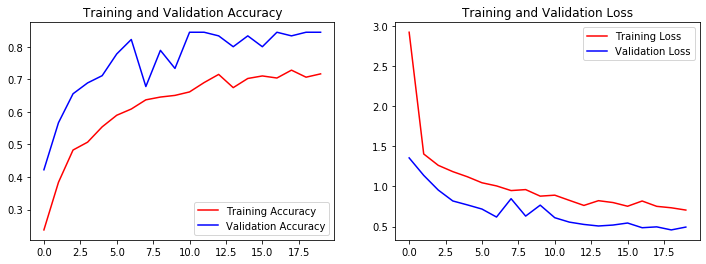

In [26]:
acc = history_ResNet152V2.history['acc']
val_acc = history_ResNet152V2.history['val_acc']
loss = history_ResNet152V2.history['loss']
val_loss = history_ResNet152V2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.legend(loc=0)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b',  label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()